<div class="alert alert-block alert-warning">

<h1>SMS Spam Collection Dataset</h1>
    
<a href="https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset">Kaggle Link</a>

    
<h2>About Dataset</h2>
    
<p>Context</p>
<blockquote>
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.
</blockquote>
    
<p>Content</p>
<blockquote>
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.
<br><br>
This corpus has been collected from free or free for research sources at the Internet:
<br><br>
- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link].
<br><br>
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link].
<br><br>
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link].
<br><br>
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link]. This corpus has been used in the following academic researches:
</blockquote>
</div>

<hr>

<div class="alert alert-block alert-info">
    <h2>Columns</h2>
    <p><strong>label:</strong> Class labels.</p>
    <p><strong>text:</strong>  SMS.</p>
</div>

## 1. Importing Libraries

In [1]:
# !pip install collections
# !pip install wordcloud
# !pip install contractions
# !pip install autocorrect
# !pip install unidecode
# !pip install gensim
# !pip install yellowbrick
# !pip install imblearn
# !pip install -U spacy
# !pip install lime

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import warnings
warnings.filterwarnings('ignore')

In [3]:
# to expand the text
import contractions

# to auto correct the words
from autocorrect import Speller

# for handling accented characters
from unidecode import unidecode

# to get list of punctiations
from string import punctuation

In [4]:
# nltk libs
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from wordcloud import WordCloud,STOPWORDS

In [6]:
import spacy
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from imblearn.over_sampling import SMOTE # for oversampling
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.pipeline import make_pipeline

In [7]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.text import FreqDistVisualizer

from lime.lime_text import LimeTextExplainer

## 2. Importing Dataset

In [8]:
sms = pd.read_csv('SMSSpamCollection',delimiter= '\t',quoting=3,names = ['label','text'])
df = sms.copy()
df.columns = map(str.lower,df.columns)

In [9]:
df.head()

label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...

## 3. E.D.A

In [10]:
df.shape

(5574, 2)

In [11]:
df.isnull().sum()

label    0
text     0
dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5574 non-null   object
 1   text    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


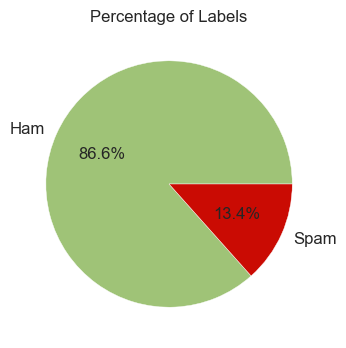

In [13]:
plt.figure(figsize = (6,4))
plt.pie(df['label'].value_counts(), labels=['Ham','Spam'], autopct='%.1f%%',colors=['g','r'],textprops={'size':12})
plt.title('Percentage of Labels')
plt.show()

### Size of the texts (by characters)

In [14]:
df['text_len'] = df['text'].apply(len)

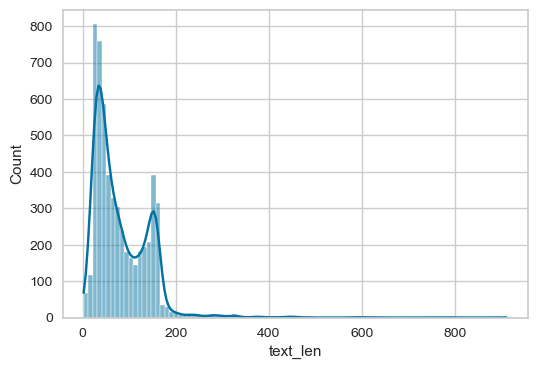

In [15]:
plt.figure(figsize = (6,4))
sns.histplot(x = 'text_len',data = df,kde=True)
plt.show()

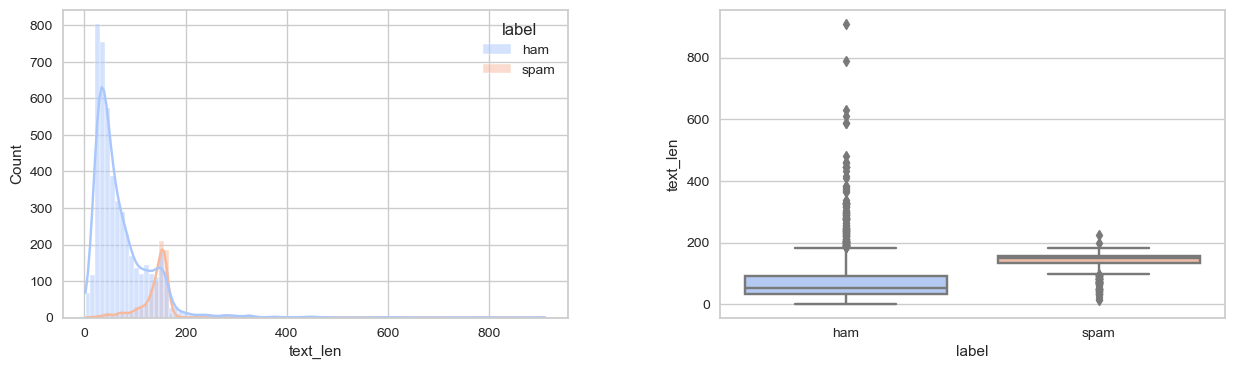

In [16]:
plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
sns.histplot(x = 'text_len',hue = 'label',data = df,palette='coolwarm', kde=True)

plt.subplot(1,2,2)
sns.boxplot(x = 'label', y = 'text_len',data = df,palette='coolwarm')

plt.subplots_adjust(wspace = 0.3)
plt.show()

### Size of the texts (by words)

In [17]:
df['text_word_count'] = df['text'].str.split().map(lambda x: len(x))

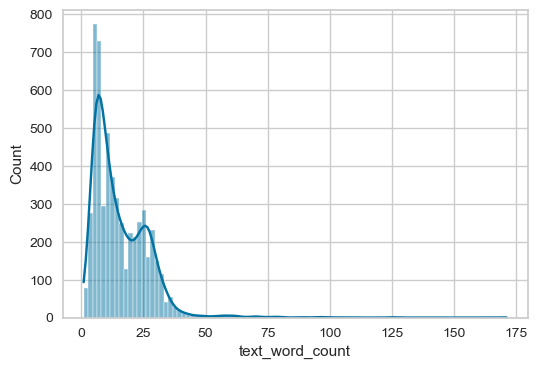

In [18]:
plt.figure(figsize = (6,4))
sns.histplot(x = 'text_word_count',data = df,kde=True)
plt.show()

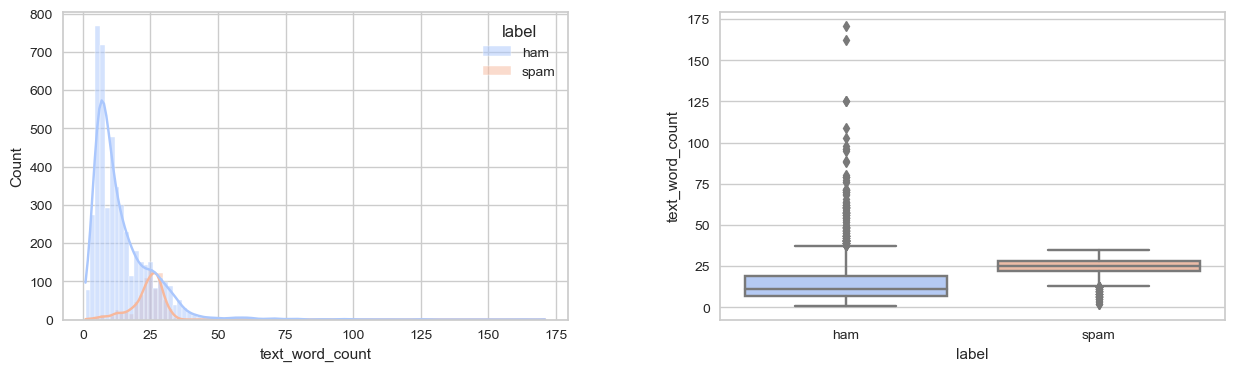

In [19]:
plt.figure(figsize = (15,4))

plt.subplot(1,2,1)
sns.histplot(x = 'text_word_count',hue = 'label',data = df,palette='coolwarm', kde=True)

plt.subplot(1,2,2)
sns.boxplot(x = 'label', y = 'text_word_count',data = df,palette='coolwarm')

plt.subplots_adjust(wspace = 0.3)
plt.show()

### 10 most frequent words

In [20]:
def most_frequent_word(text_list,n = 10,x = 1):
    vectorizer = CountVectorizer(ngram_range=(x,x))
    docs = vectorizer.fit_transform(text_list)
    features = vectorizer.get_feature_names_out()
    
    plt.figure(figsize = (8,4))
    visualizer = FreqDistVisualizer(features = features, orient='h', n = n)
    visualizer.fit(docs)
    plt.yticks(size = 10)
    visualizer.show()

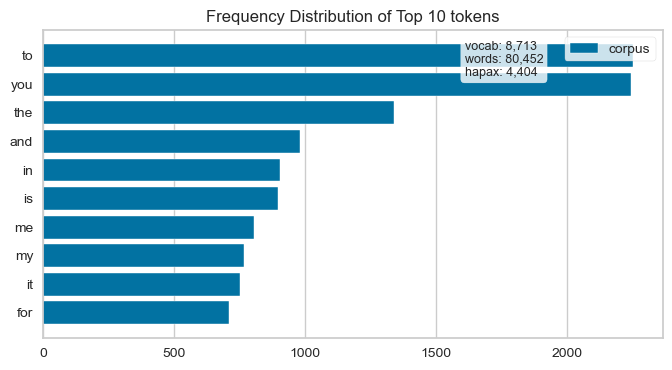

In [21]:
most_frequent_word(df['text'].tolist())

#### Bigrams

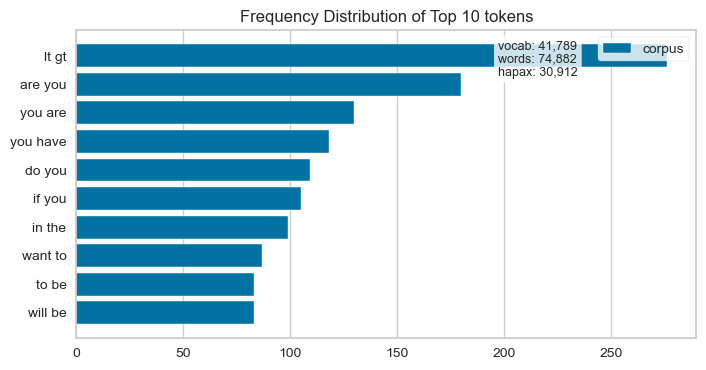

In [22]:
most_frequent_word(df['text'].tolist(),x = 2)

#### Trigrams

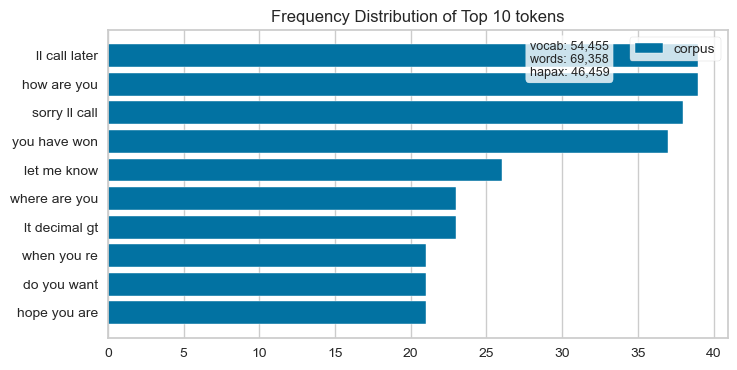

In [23]:
most_frequent_word(df['text'].tolist(),x = 3)

#### Trigrams for ham texts

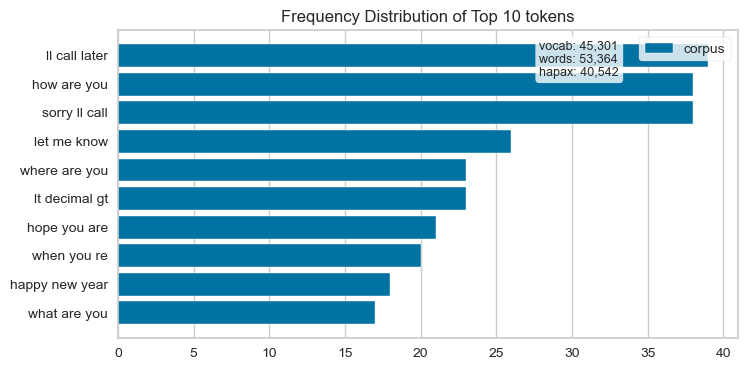

In [24]:
most_frequent_word(df[df['label'] == 'ham']['text'].tolist(), x = 3)

#### Trigrams for spam texts

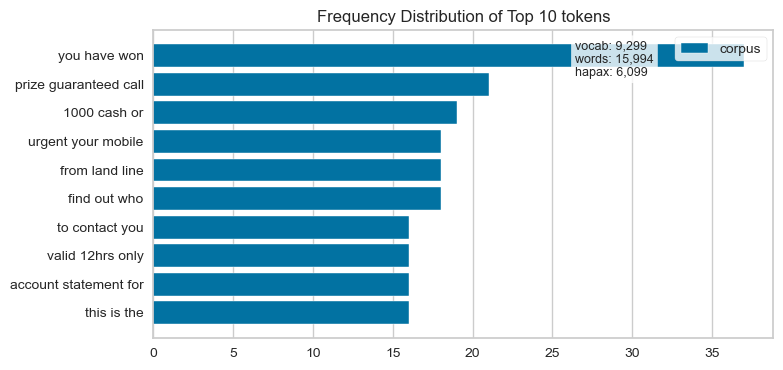

In [25]:
most_frequent_word(df[df['label'] == 'spam']['text'].tolist(), x = 3)

### Word Cloud

In [26]:
def plot_word_cloud(text):
    
    word_cloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='white',
        width = 2500,
        height = 2000
    ).generate(' '.join(text))
    
    plt.figure(figsize = (6,6))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

### Ham texts

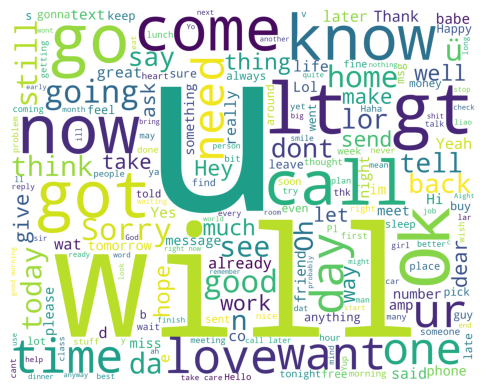

In [27]:
plot_word_cloud(df[df['label'] == 'ham']['text'])

### Spam texts

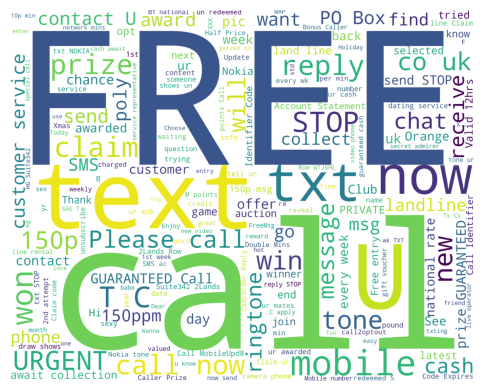

In [28]:
plot_word_cloud(df[df['label'] == 'spam']['text'])

## 3. Text Preprocessing

### 3.1. Remove spaces

In [29]:
def remove_spaces(text):
    clean_text = text.replace('\\n',' ').replace('\t',' ').replace('\\',' ')
    return clean_text

### 3.2. Expanding texts (don't ->  do not)

In [30]:
def expand_text(text):
    ex_text = contractions.fix(text)
    return ex_text

### 3.3. Handling accented characters

In [31]:
def handling_accented(text):
    return unidecode(text)

### 3.4. Cleaning texts

In [32]:
def clean_text(text):
    token = word_tokenize(text)
    clean_text = [
        i.lower() for i in token 
        if (i not in punctuation) 
        and (i.lower() not in stopword) 
        and (i.isalpha()) 
        and (len(i) > 2)
    ]
    return clean_text

### 3.5. Text auto correction

In [33]:
def auto_correct(text):
    spell = Speller(lang='en')
    return spell(text)

### 3.6. Getting root of the words (Lemmatization)

In [34]:
def lemmatization(text):
    lem = WordNetLemmatizer()
    lst = []
    for i in text:
        lem_words = lem.lemmatize(i)
        lst.append(lem_words)
        
    return ' '.join(lst)

In [35]:
stopword = stopwords.words("english")

stopword.remove("no") 
stopword.remove("not")
stopword.remove("nor")

In [36]:
df['clean_text'] = df['text'].apply(remove_spaces)
df['clean_text'] = df['clean_text'].apply(expand_text)
df['clean_text'] = df['clean_text'].apply(handling_accented)
df['clean_text'] = df['clean_text'].apply(clean_text)
df['clean_text'] = df['clean_text'].apply(lambda x: auto_correct(x) if isinstance(x,str) or isinstance(x, bytes) else x)
df['clean_text'] = df['clean_text'].apply(lemmatization)

### 4. E.D.A Continue

### Compare size of the texts (by character)

In [37]:
df['clean_text_len'] = df['clean_text'].apply(len)

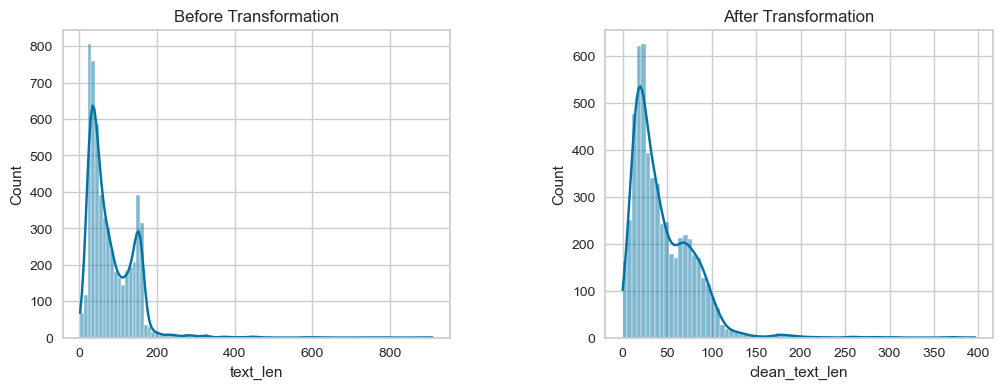

In [38]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.histplot(x = 'text_len',data = df,kde = True)
plt.title('Before Transformation')

plt.subplot(1,2,2)
sns.histplot(x = 'clean_text_len',data = df,kde = True)
plt.title('After Transformation')

plt.subplots_adjust(wspace = 0.4)

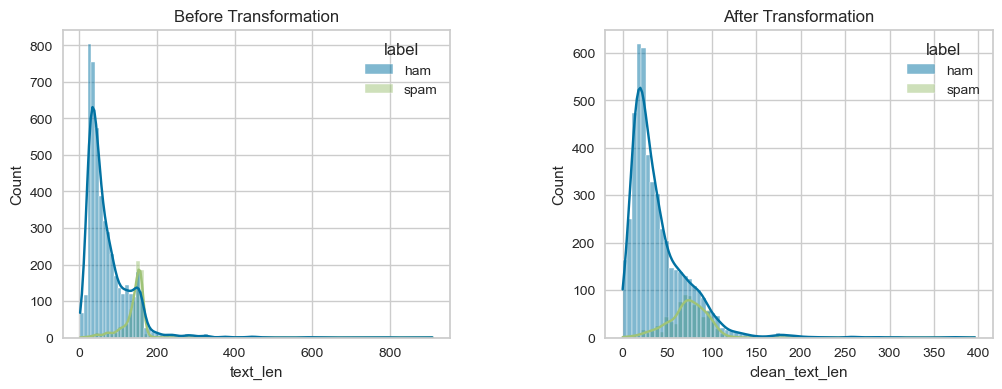

In [39]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.histplot(x = 'text_len',data = df,hue = 'label',kde = True)
plt.title('Before Transformation')

plt.subplot(1,2,2)
sns.histplot(x = 'clean_text_len',data = df,hue = 'label',kde = True)
plt.title('After Transformation')

plt.subplots_adjust(wspace = 0.4)

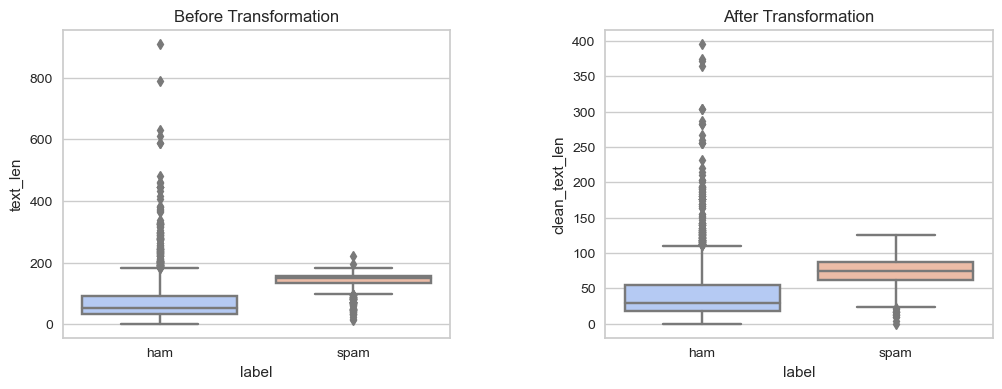

In [40]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.boxplot(x = 'label', y = 'text_len', data = df,palette='coolwarm')
plt.title('Before Transformation')

plt.subplot(1,2,2)
sns.boxplot(x = 'label', y = 'clean_text_len', data = df, palette='coolwarm')
plt.title('After Transformation')

plt.subplots_adjust(wspace = 0.4)

### Compare size of the texts (by word)

In [41]:
df['clean_text_word_count'] = df['clean_text'].str.split().map(lambda x: len(x))

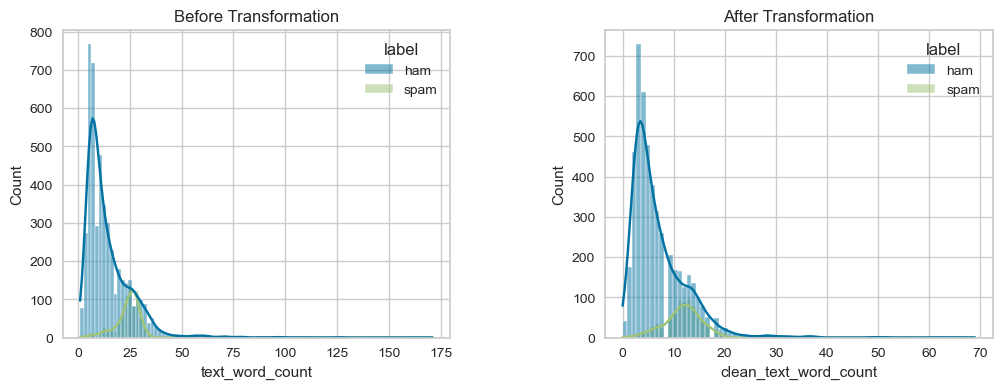

In [42]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.histplot(x = 'text_word_count',data = df, hue = 'label', kde=True)
plt.title("Before Transformation")

plt.subplot(1,2,2)
sns.histplot(x = 'clean_text_word_count',data = df,hue = 'label',kde=True)
plt.title("After Transformation")

plt.subplots_adjust(wspace = 0.4)
plt.show()

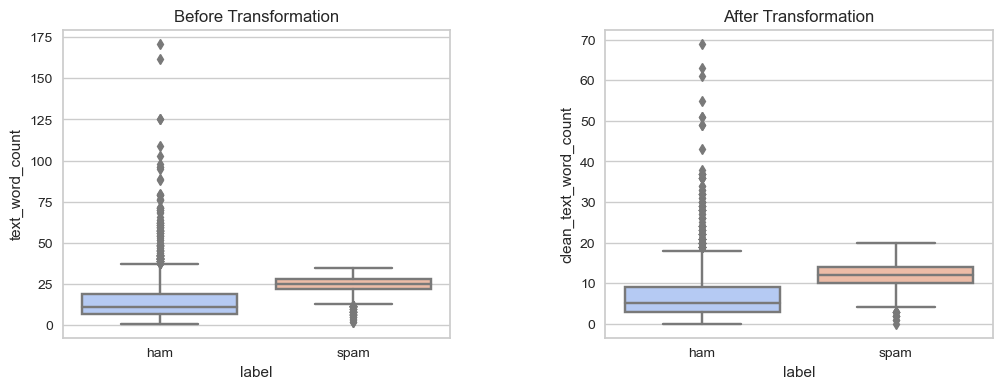

In [43]:
plt.figure(figsize = (12,4))

plt.subplot(1,2,1)
sns.boxplot(x = 'label', y = 'text_word_count', data = df,palette='coolwarm')
plt.title('Before Transformation')

plt.subplot(1,2,2)
sns.boxplot(x = 'label', y = 'clean_text_word_count', data = df, palette='coolwarm')
plt.title('After Transformation')

plt.subplots_adjust(wspace = 0.4)

### 10 most frequent word

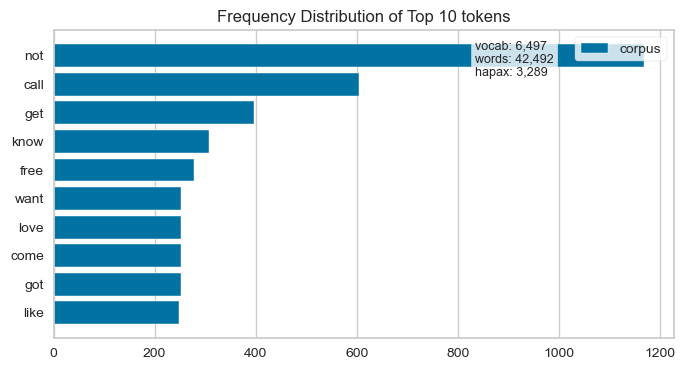

In [44]:
most_frequent_word(df['clean_text'].tolist())

#### Bigrams

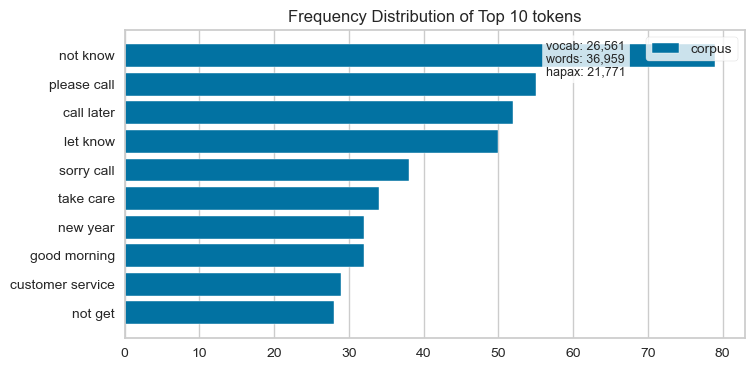

In [45]:
most_frequent_word(df['clean_text'].tolist(), x = 2)

#### Trigrams

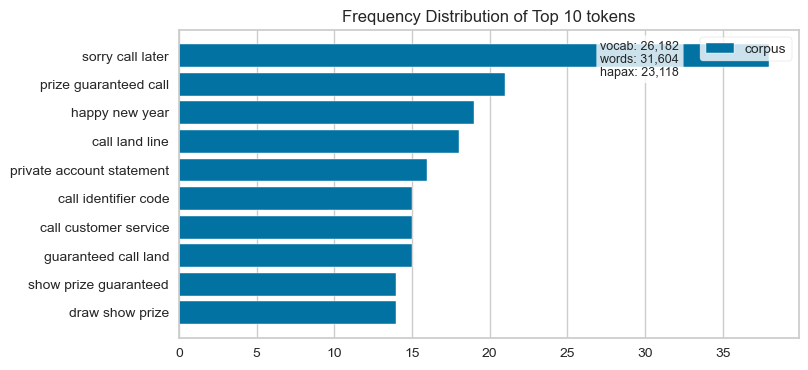

In [46]:
most_frequent_word(df['clean_text'].tolist(),x = 3)

#### Trigrams for ham texts

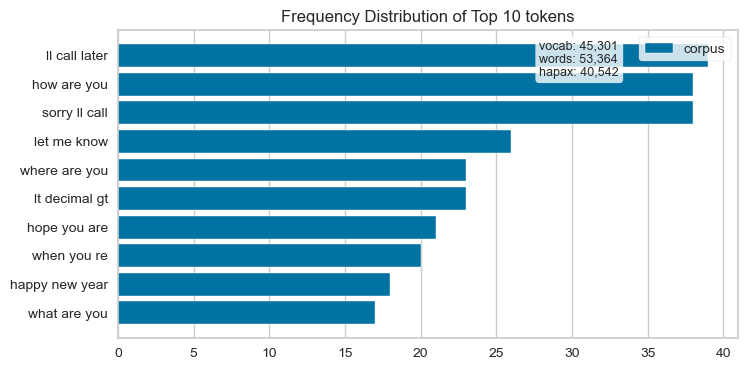

In [47]:
most_frequent_word(df[df['label'] == 'ham']['text'].tolist(), x = 3)

#### Trigrams for spam texts

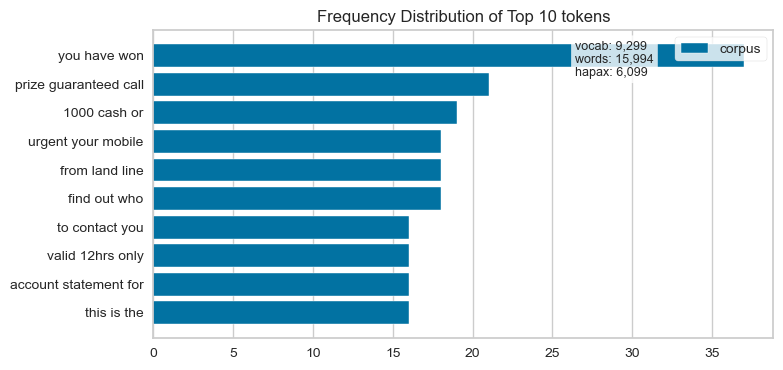

In [48]:
most_frequent_word(df[df['label'] == 'spam']['text'].tolist(), x = 3)

### Compare word clouds after transformation the texts

In [49]:
def compare_word_clouds(label):
    plt.figure(figsize = (20,10))
    
    plt.subplot(1,2,1)
    word_cloud = WordCloud(
        stopwords= STOPWORDS, 
        background_color='white',
        width = 2500, 
        height = 2000
    ).generate(' '.join(df[df['label'] == label]['text']))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title('Before Transformation',size = 20, y = 1.02)
    
    plt.subplot(1,2,2)
    word_cloud = WordCloud(
        stopwords = STOPWORDS, 
        background_color='white',
        width = 2500, 
        height = 2000
    ).generate(' '.join(df[df['label'] == label]['clean_text']))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.title('After Transformation',size = 20, y = 1.02)

#### Compare ham texts 

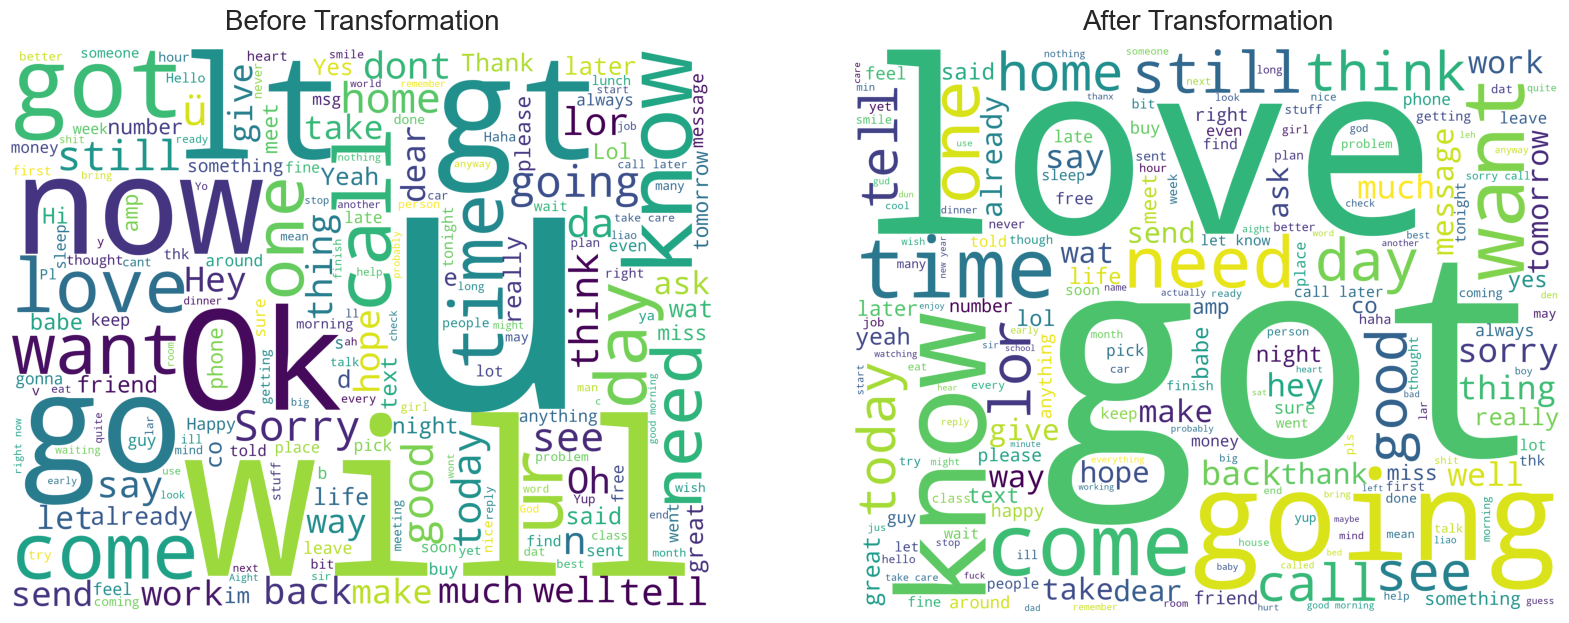

In [50]:
compare_word_clouds('ham')

#### Compare spam texts

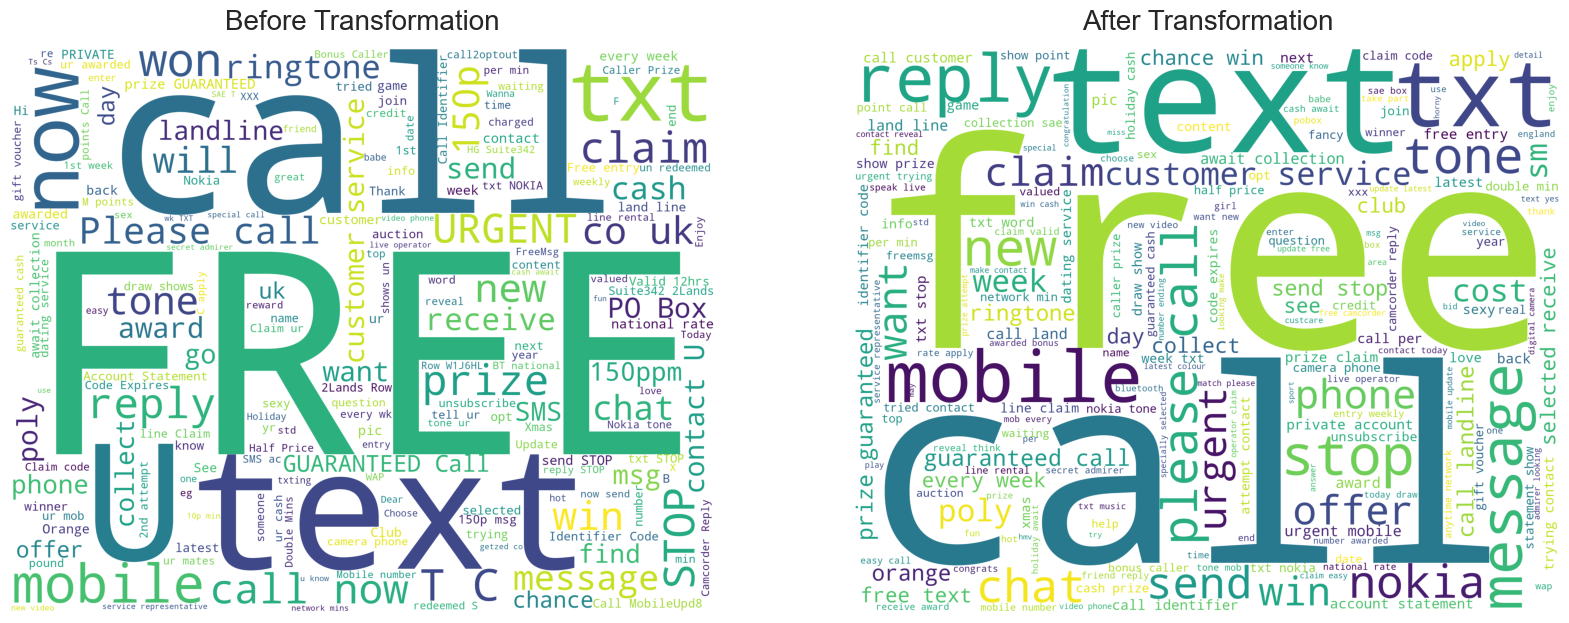

In [51]:
compare_word_clouds('spam')

## 5. Create train and test sets

In [52]:
X = df[['clean_text']]
y = df['label']

In [53]:
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.3,random_state=0)

## 6. TF-IDF Vectorizer

In [54]:
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train['clean_text'])
X_test_vec = vectorizer.transform(X_test['clean_text'])

### Oversampling

In [55]:
print("Before".center(20,'_'))
y_train.value_counts()

_______Before_______


ham     3378
spam     523
Name: label, dtype: int64

In [56]:
smote = SMOTE()
X_train_vec_smote,y_train_smote = smote.fit_resample(X_train_vec,y_train)

In [57]:
print("After".center(20,'_'))
y_train_smote.value_counts()

_______After________


ham     3378
spam    3378
Name: label, dtype: int64

In [58]:
X_train_vec_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data = X_train_vec_smote.toarray())
X_test_vec_df = pd.DataFrame(columns=vectorizer.get_feature_names_out(), data = X_test_vec.toarray())

## 7. Multinomial Naive Bayes

In [59]:
clf = MultinomialNB()
clf_model = clf.fit(X_train_vec_df,y_train_smote)
y_pred = clf_model.predict(X_test_vec_df)

In [60]:
print(f"Accuracy Score: {round(accuracy_score(y_test,y_pred),2)}")

Accuracy Score: 0.95


In [61]:
cvs = cross_val_score(estimator=clf, X=X_train_vec_df, y=y_train_smote, cv = 5)
print(f"Cross Validation Score: {round(cvs.mean(),2)}")

Cross Validation Score: 0.97


In [62]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         ham       0.99      0.95      0.97      1449
        spam       0.74      0.91      0.82       224

    accuracy                           0.95      1673
   macro avg       0.86      0.93      0.89      1673
weighted avg       0.95      0.95      0.95      1673



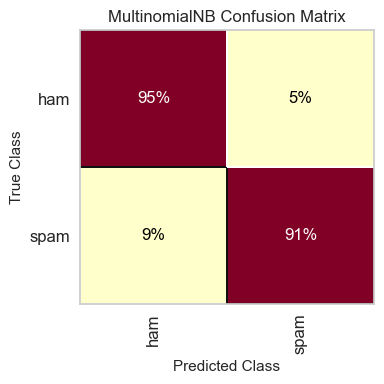

In [63]:
plt.figure(figsize = (4,4))
visualizer = ConfusionMatrix(clf_model, percent = True)
visualizer.class_counts_ = 2
visualizer.score(X_test_vec_df, y_test)
visualizer.show()
plt.show()

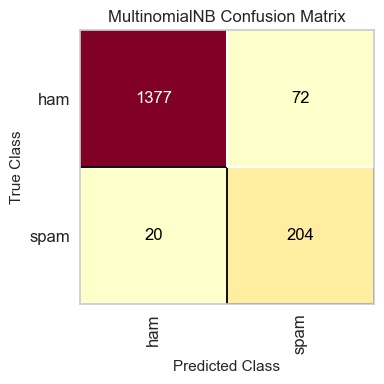

In [64]:
plt.figure(figsize = (4,4))
visualizer = ConfusionMatrix(clf_model)
visualizer.class_counts_ = 2
visualizer.score(X_test_vec_df,y_test)
visualizer.show()
plt.show()

## 8. Feature Importance

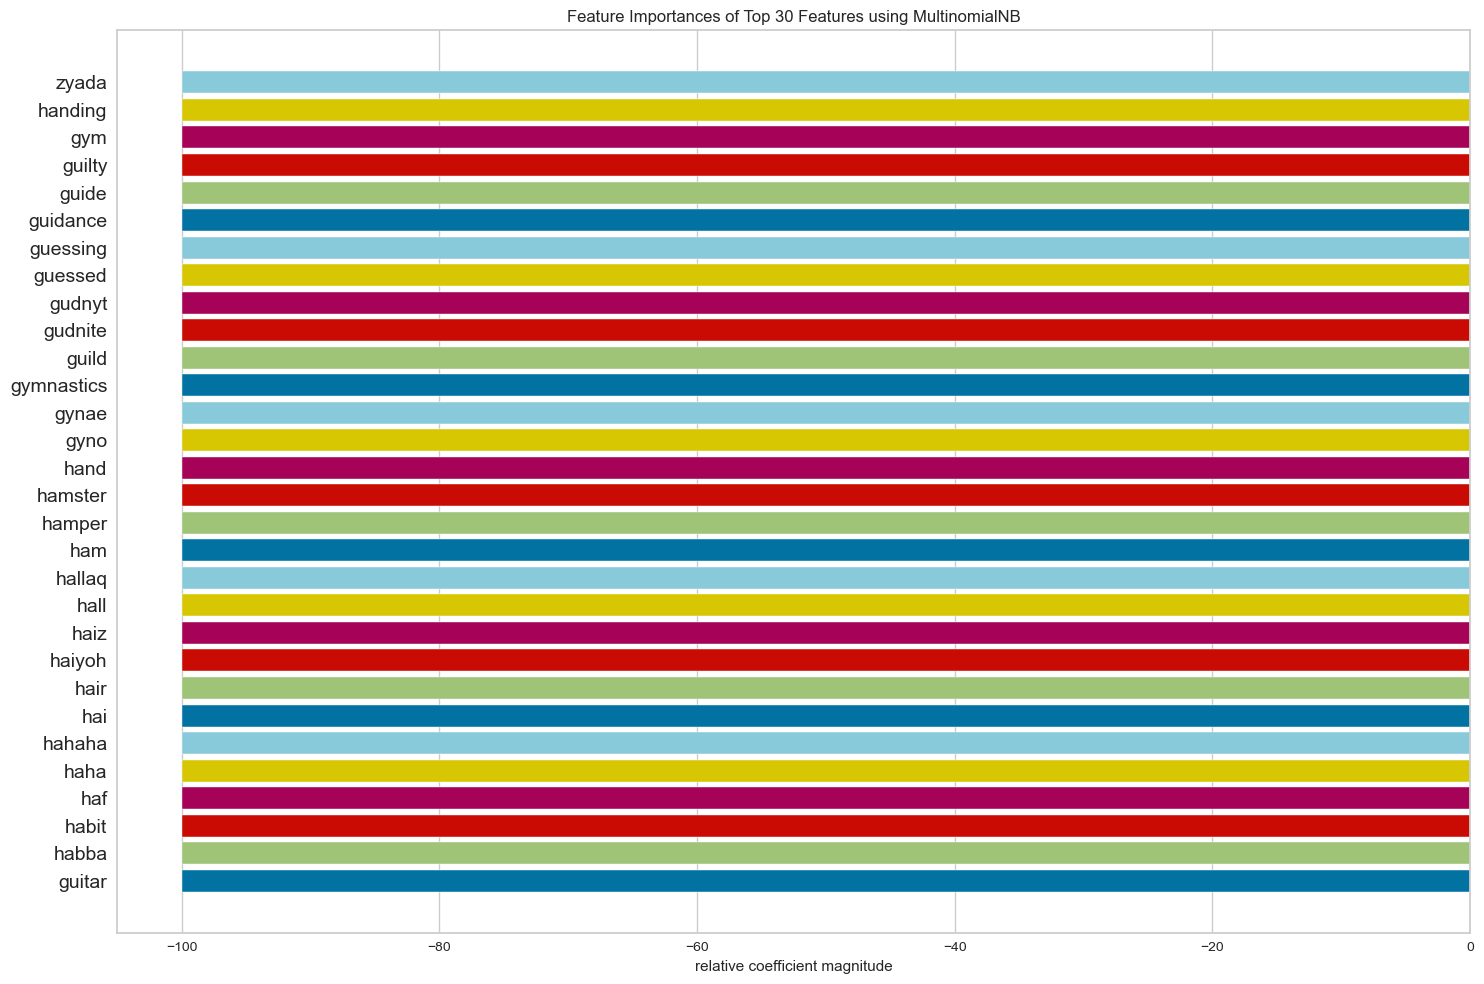

In [65]:
plt.figure(figsize = (15,10))
visualizer = FeatureImportances(clf_model,topn=30)
visualizer.fit(X_test_vec_df,y_test)
plt.yticks(size = 14)
visualizer.show()
plt.show()

## 9. Prediction

### Explainer

In [66]:
c = make_pipeline(vectorizer,clf_model)

explainer = LimeTextExplainer(class_names=['ham','spam'])

In [67]:
explainer.class_names

['ham', 'spam']

### Some Spam SMS Examples

- Federal Credit Union ALERT: Your Credit Card has been temporarily LOCKED. Please call Card Services line (012) 345-6789


- URGENT your grandson was arrested last night in Mexico. Need bail money immediately Western Union Wire 9,500 dollars http://link/


- Your IRS tax refund is pending acceptance. Must accept within 24 hours: http://link/


- Wells Fargo Bank: Your account is temporarily locked. Please log in at http://link/ to secure your account.

In [68]:
text = input("Enter a text:\n-> ")
print('\n')
if text != "":
    exp = explainer.explain_instance(text, c.predict_proba, labels=[0,1])
    exp.show_in_notebook()
    
else:
    print("Invalid text!")

Enter a text:
-> Federal Credit Union ALERT: Your Credit Card has been temporarily LOCKED. Please call Card Services line (012) 345-6789


